- `conda activate mri`
  - (created in `0_setup.ipynb`)

---

- `jupyter lab` => open this file

---

- Selected Jupyter kernel (`ms_classification`)
  - (created in `0_setup.ipynb`)

---

---

# Imports & Definitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.lines import Line2D
from scipy.stats import betabinom
import seaborn as sns
sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1.2,
    rc={
        'figure.dpi': 300,
        'savefig.dpi': 600,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans']
    }
)
sns.set_palette('colorblind')

---

# Read in Results

In [2]:
# --- read in all table ---
df_runs_scn_lvl_cc = pd.read_csv('___conformal_coverage_guarantees__runs__scan_level__class_conditional.csv')

# --- add class_conditional flag and standardize variant_test_data (drop leading/trailing underscores) ---
for df, flag in [
    (df_runs_scn_lvl_cc,    True),
]:
    df['class_conditional'] = flag
    df['variant_test_data'] = df['variant_test_data'].str.strip('_')

---

---

---

## Impact of Calibration Set Size on Empirical Coverage Distribution

**Key Takeaway:**  
Calibration set size directly governs the variability of conformal coverage. In the class-conditional conformal prediction exemplar shown below, each class’s nonconformity scores are calibrated separately—resulting in different effective calibration set sizes per class. Smaller calibration samples yield wider prediction intervals and increased coverage variance, illustrating how calibration set size alone can drive empirical coverage behavior.


---

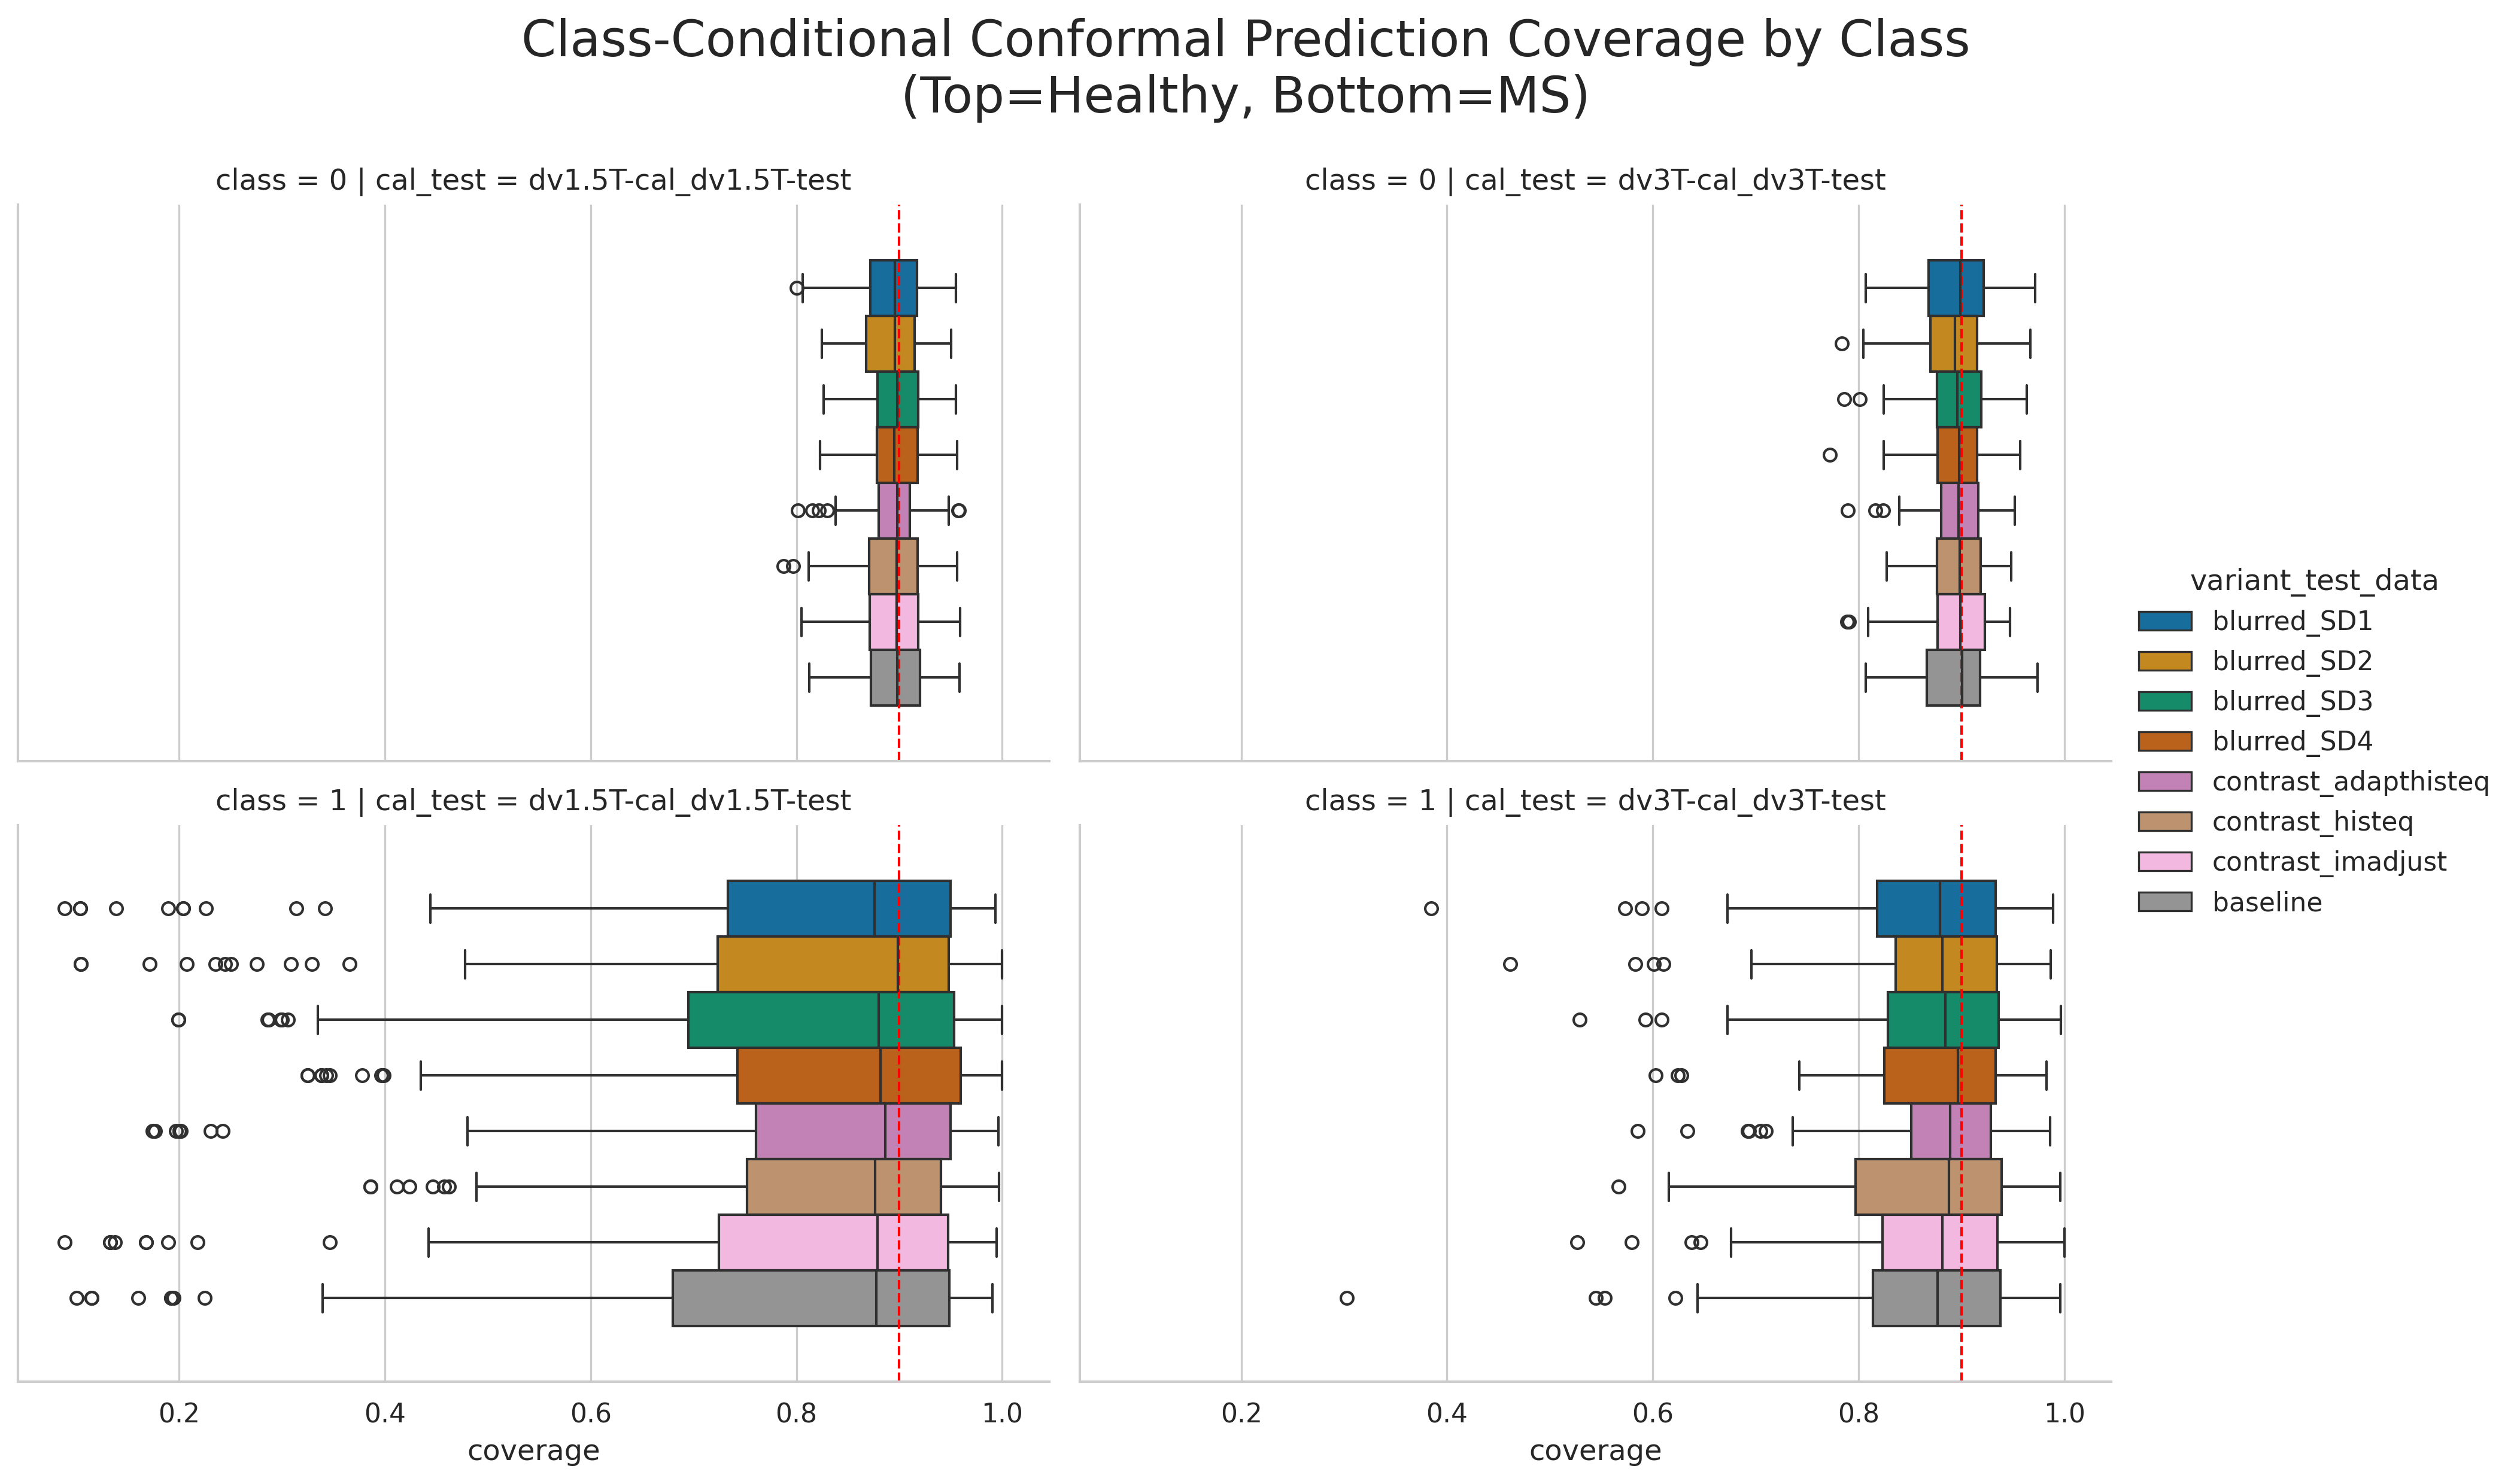

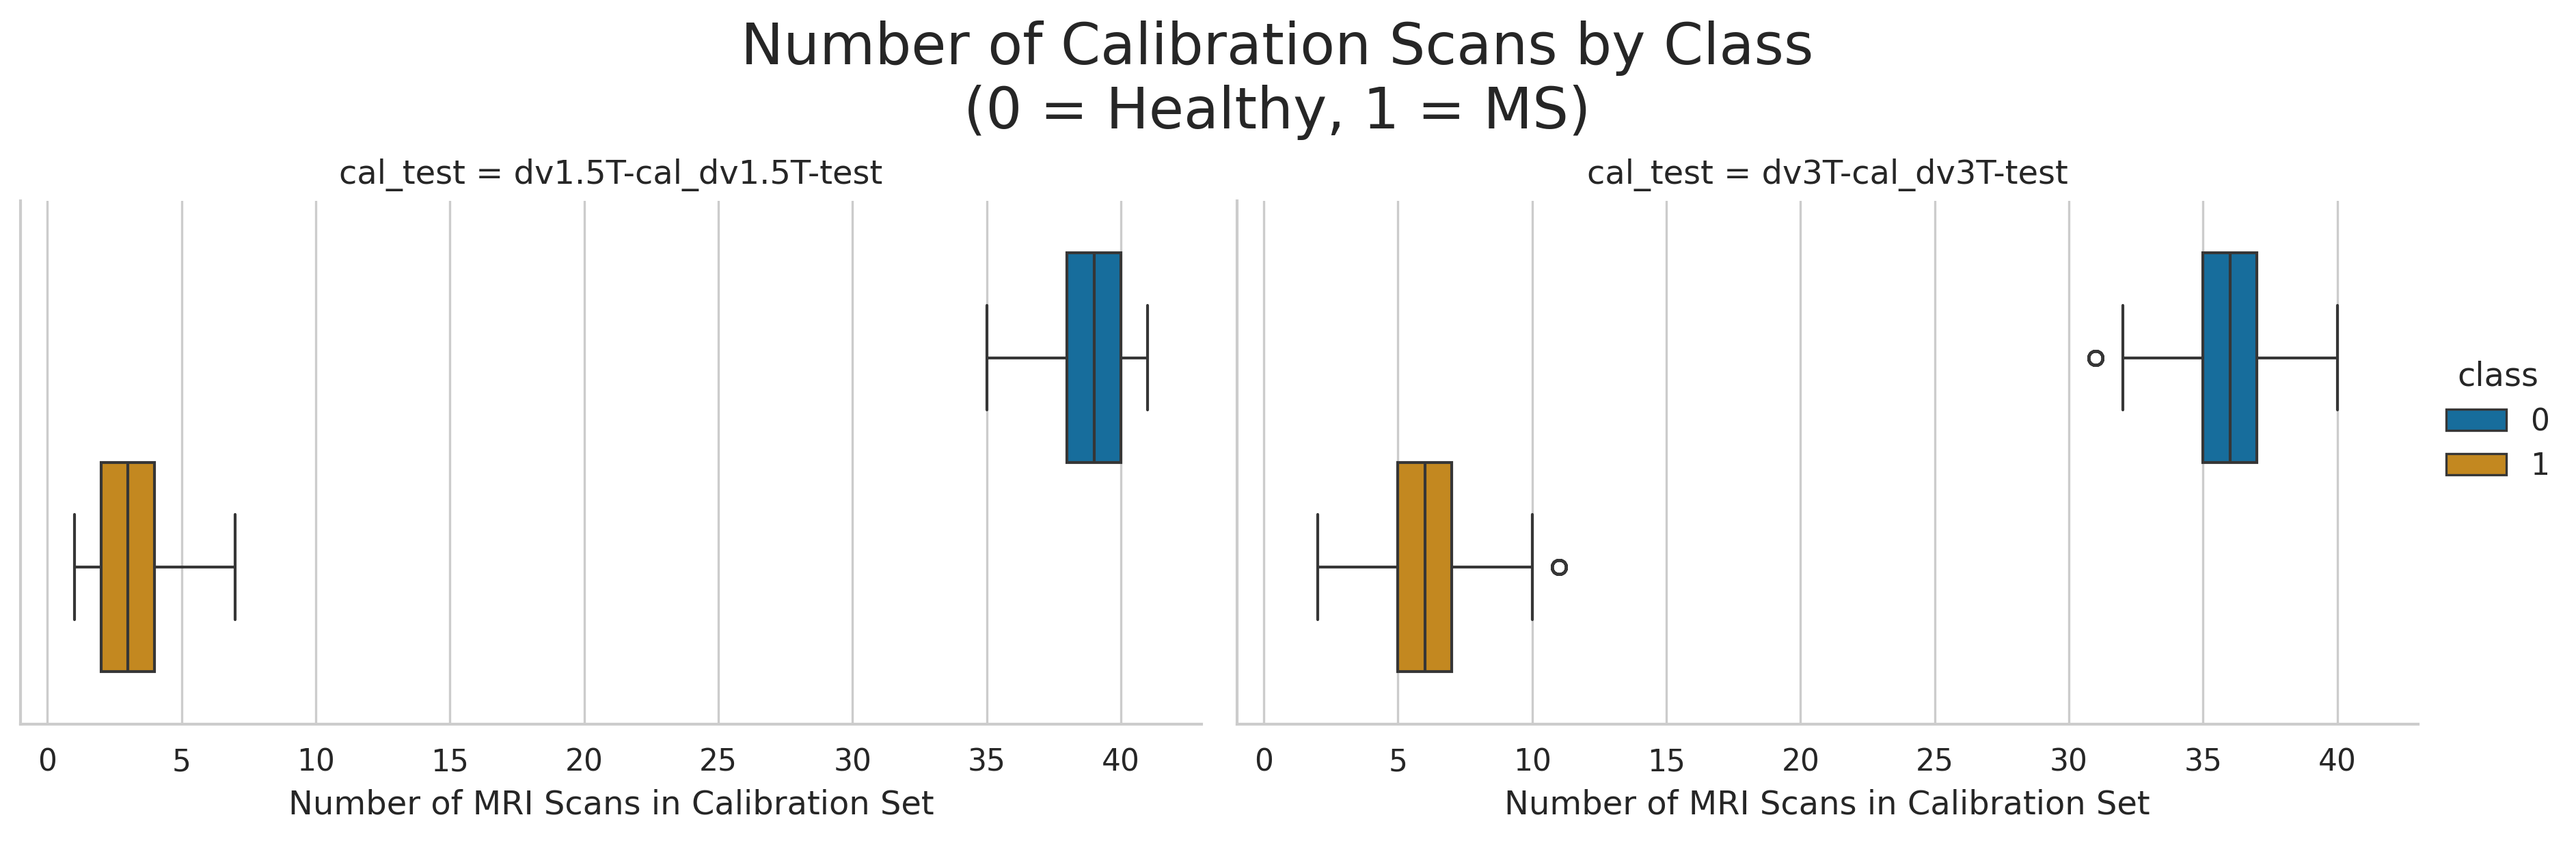

In [3]:
# exclude setups designed to violate assumptions, as that is not the focus here
df_cc = df_runs_scn_lvl_cc[~df_runs_scn_lvl_cc['cal_test'].str.contains('baseline')]
# coverage by class & variant
g1 = sns.catplot(data=df_cc, row='class', col='cal_test', x='coverage', hue='variant_test_data', kind='box', height=4, aspect=1.5)
for ax in g1.axes.flatten():
    ax.axvline(0.9, color='red', linestyle='--', linewidth=1)
g1.fig.suptitle("Class-Conditional Conformal Prediction Coverage by Class\n(Top=Healthy, Bottom=MS)", y=1.03, fontsize='20')
g1.fig.subplots_adjust(top=0.90)
# distribution of n_cal_cls
g2 = sns.catplot(data=df_cc, col='cal_test', x='n_cal_cls', hue='class', kind='box', height=4, aspect=1.5)
g2.set_axis_labels("Number of MRI Scans in Calibration Set", "")
g2.fig.suptitle("Number of Calibration Scans by Class\n(0 = Healthy, 1 = MS)", y=1.02, fontsize='20')
g2.fig.subplots_adjust(top=0.8)
plt.show()

---

__Create publication-quality version__

---

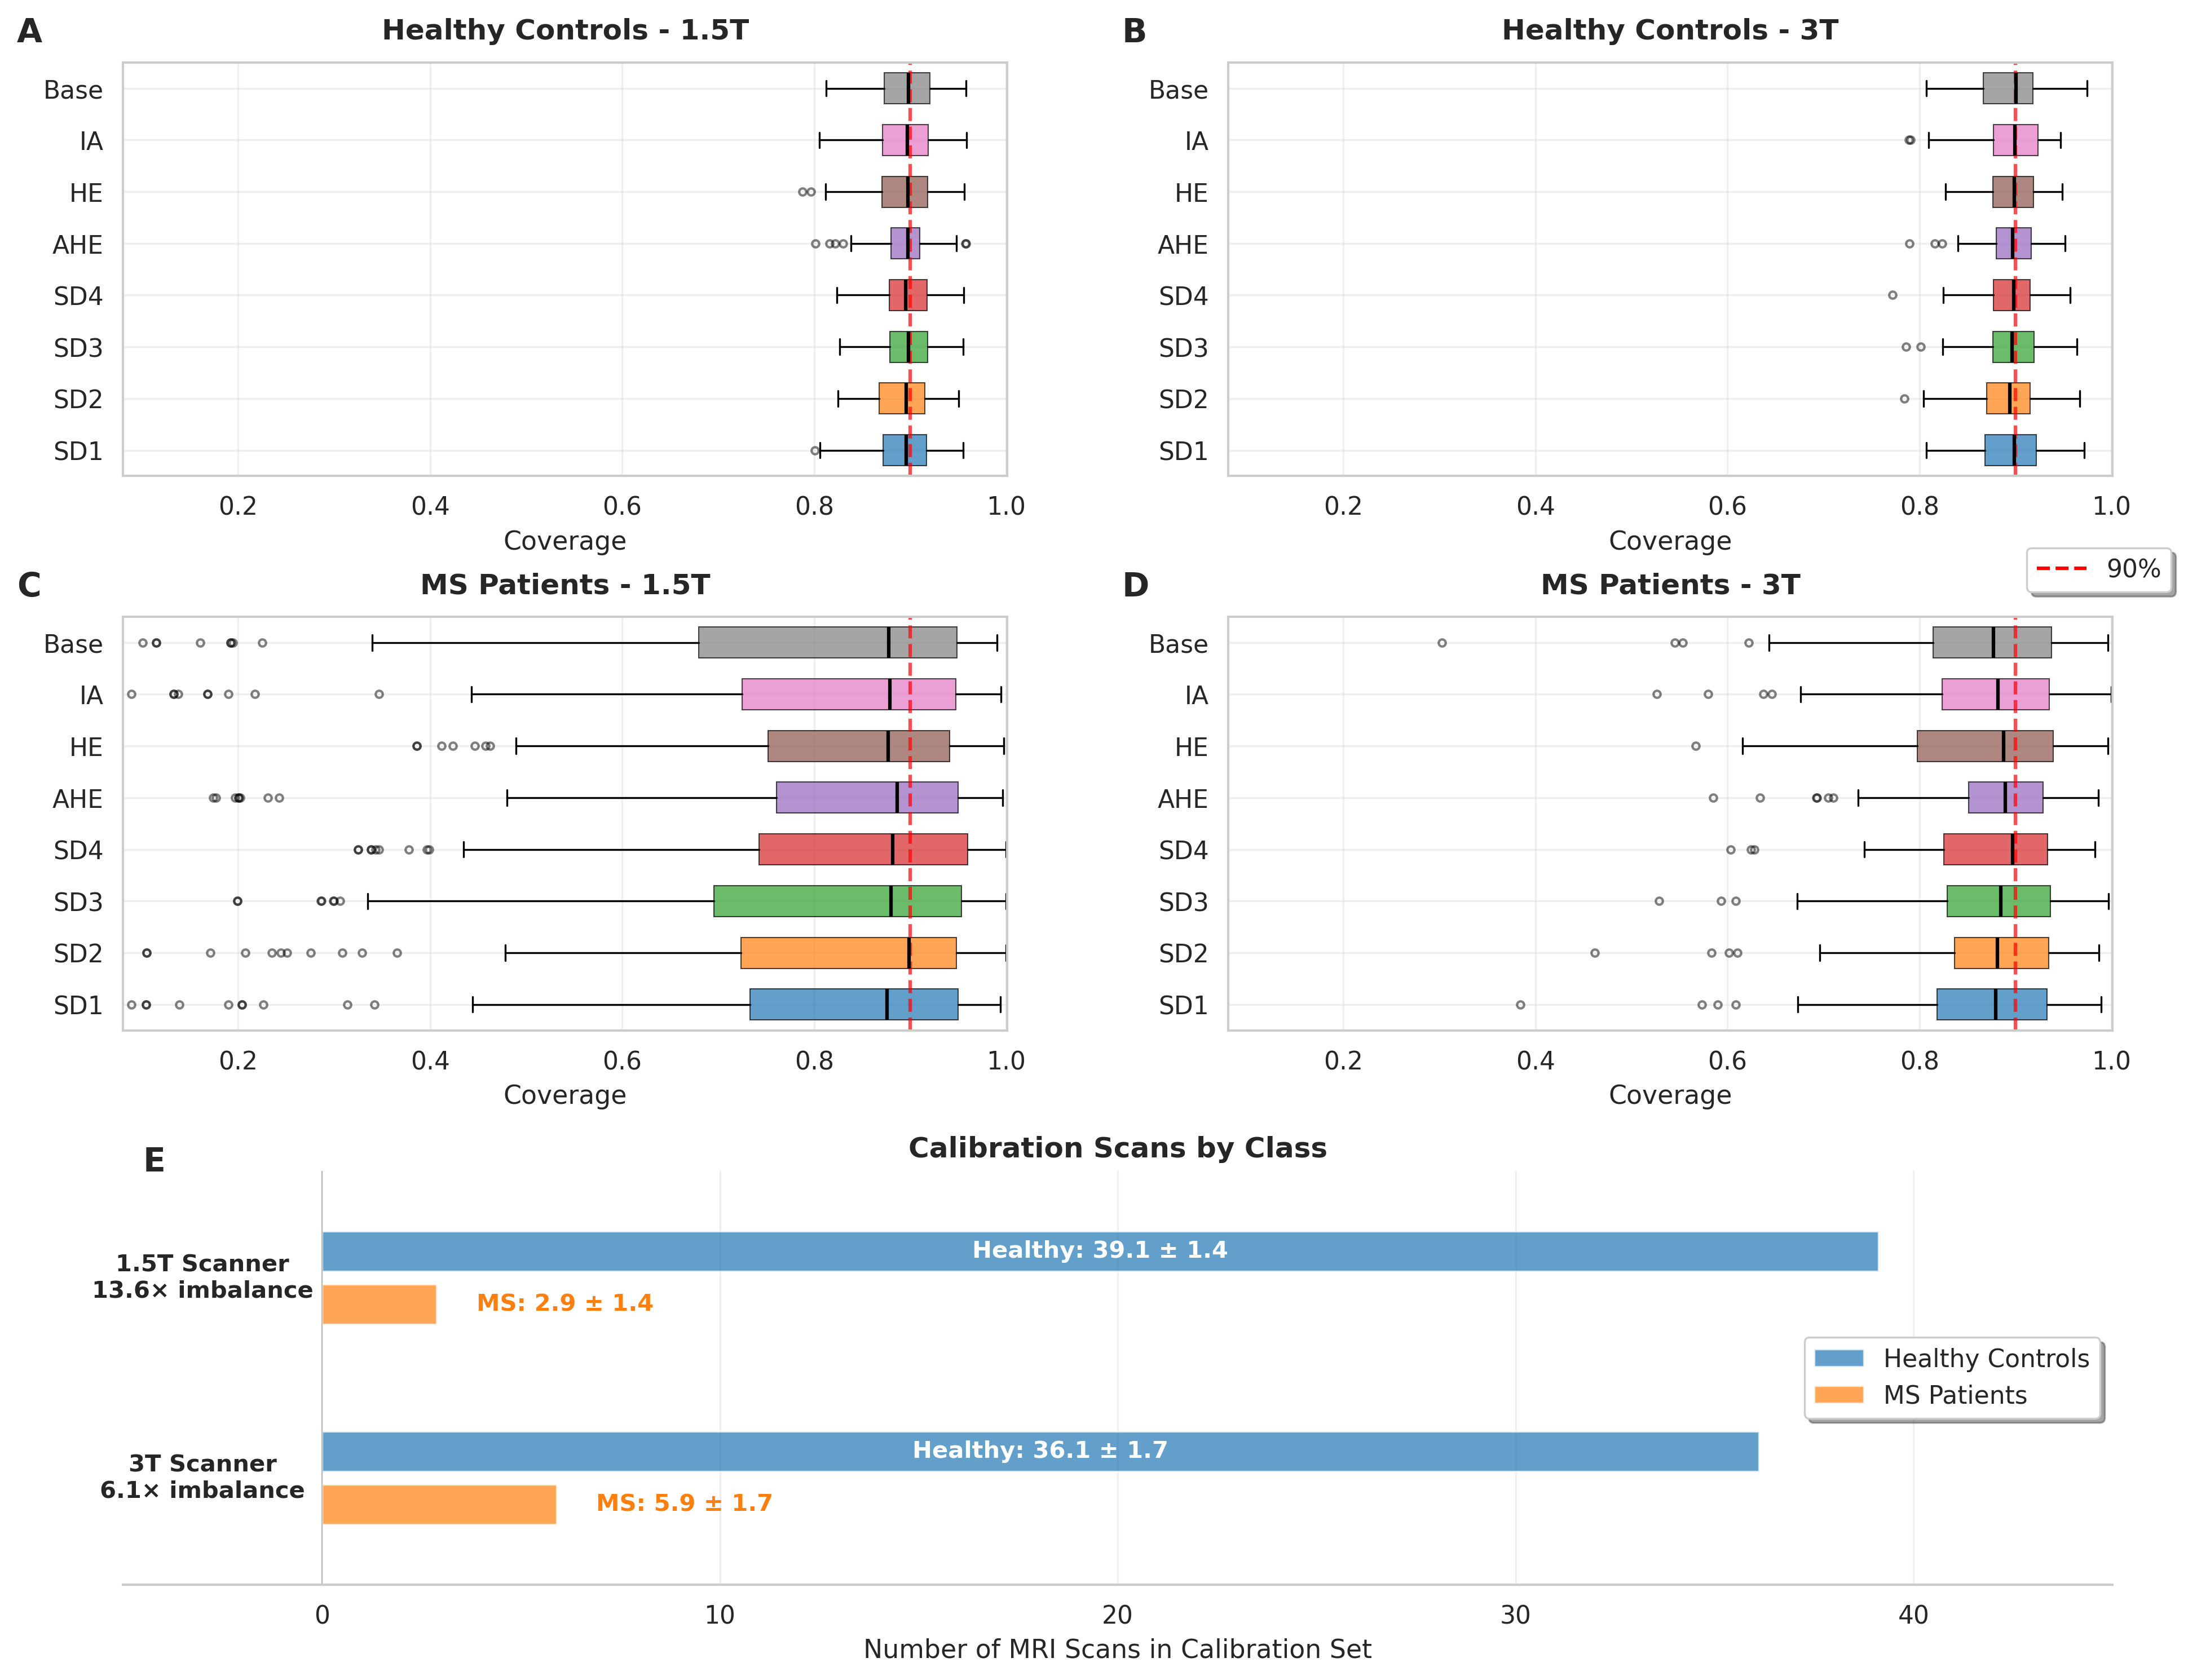

In [4]:
# Set publication-ready style
sns.set_palette("husl")

# Define colors for consistency
VARIANT_COLORS = {
    'SD1': '#1f77b4',
    'SD2': '#ff7f0e', 
    'SD3': '#2ca02c',
    'SD4': '#d62728',
    'AHE': '#9467bd',
    'HE': '#8c564b',
    'IA': '#e377c2',
    'Base': '#7f7f7f'
}

CLASS_COLORS = {
    'Healthy': '#1f77b4',
    'MS': '#ff7f0e'
}

variant_map = {
    'blurred_SD1': 'SD1',
    'blurred_SD2': 'SD2',
    'blurred_SD3': 'SD3',
    'blurred_SD4': 'SD4',
    'contrast_adapthisteq': 'AHE',
    'contrast_histeq': 'HE',
    'contrast_imadjust': 'IA',
    'baseline': 'Base'
}
df = df_cc.copy()
df['variant_display'] = df['variant_test_data'].map(variant_map)

def create_figure(df, save_path=None):
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.34, wspace=0.25, 
                          left=0.08, right=0.92, top=0.95, bottom=0.05)
    
    # Panel configurations
    panels = [
        {'ax': fig.add_subplot(gs[0, 0]), 'label': 'A', 'cal_test': 'dv1.5T-cal_dv1.5T-test', 
         'class': 0, 'title': 'Healthy Controls - 1.5T'},
        {'ax': fig.add_subplot(gs[0, 1]), 'label': 'B', 'cal_test': 'dv3T-cal_dv3T-test',
         'class': 0, 'title': 'Healthy Controls - 3T'},
        {'ax': fig.add_subplot(gs[1, 0]), 'label': 'C', 'cal_test': 'dv1.5T-cal_dv1.5T-test',
         'class': 1, 'title': 'MS Patients - 1.5T'},
        {'ax': fig.add_subplot(gs[1, 1]), 'label': 'D', 'cal_test': 'dv3T-cal_dv3T-test',
         'class': 1, 'title': 'MS Patients - 3T'},
    ]
    
    variants = ['SD1', 'SD2', 'SD3', 'SD4', 'AHE', 'HE', 'IA', 'Base']
    
    # Draw coverage panels (A-D)
    for panel in panels:
        ax = panel['ax']
        
        # Add panel label
        ax.text(-0.12, 1.05, panel['label'], transform=ax.transAxes, 
                fontsize=14, fontweight='bold')
        
        # Filter data
        panel_data = df[(df['cal_test'] == panel['cal_test']) & 
                       (df['class'] == panel['class'])]
        
        # Prepare data for boxplot
        data_by_variant = []
        positions = []
        colors = []

        for i, variant in enumerate(variants):
            variant_data = panel_data[panel_data['variant_display'] == variant]['coverage'].values
            if len(variant_data) > 0:
                data_by_variant.append(variant_data)
                positions.append(i)
                colors.append(VARIANT_COLORS[variant])
        
        # Create boxplot
        bp = ax.boxplot(data_by_variant, positions=positions, vert=False, 
                       widths=0.6, patch_artist=True, 
                       boxprops=dict(alpha=0.7),
                       medianprops=dict(color='black', linewidth=1.5),
                       whiskerprops=dict(linewidth=0.8),
                       capprops=dict(linewidth=0.8),
                       flierprops=dict(marker='o', markersize=3, alpha=0.5))
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')
            patch.set_linewidth(0.5)
        
        # Add target line
        ax.axvline(0.9, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        
        # Formatting
        ax.set_xlim(0.08, 1.001)
        ax.set_yticks(range(len(variants)))
        ax.set_yticklabels(variants)
        ax.set_xlabel('Coverage', fontsize=11)
        ax.set_title(panel['title'], fontsize=12, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3)

    # Panel E - Proportional bars showing calibration set imbalance
    ax_e = fig.add_subplot(gs[2, :])  # Span both columns
    
    # Add panel label
    ax_e.text(0.01, 1, 'E', transform=ax_e.transAxes,
             fontsize=14, fontweight='bold')
    
    # Calculate average calibration sizes and imbalances
    imbalances = {}
    for field in ['1.5T', '3T']:
        cal_test = f'dv{field}-cal_dv{field}-test'
        field_data = df[df['cal_test'] == cal_test]
        
        # Get average n_cal_cls for each class
        healthy_n = field_data[field_data['class'] == 0]['n_cal_cls'].mean()
        ms_n = field_data[field_data['class'] == 1]['n_cal_cls'].mean()
        
        # Calculate standard deviations
        healthy_std = field_data[field_data['class'] == 0]['n_cal_cls'].std()
        ms_std = field_data[field_data['class'] == 1]['n_cal_cls'].std()
        
        imbalances[field] = {
            'healthy': healthy_n, 
            'ms': ms_n, 
            'ratio': healthy_n/ms_n,
            'healthy_std': healthy_std,
            'ms_std': ms_std
        }
    
    # Create proportional bars
    y_positions = [1.5, 0]  # Positions for 1.5T and 3T
    bar_height = 0.3
    
    for i, (field, imb) in enumerate([('1.5T', imbalances['1.5T']), 
                                       ('3T', imbalances['3T'])]):
        y_base = y_positions[i]
        
        # Healthy bar
        ax_e.barh(y_base + bar_height/2 + 0.05, imb['healthy'], height=bar_height,
                 color=CLASS_COLORS['Healthy'], alpha=0.7, 
                 label='Healthy Controls' if i == 0 else None,
                 error_kw={'linewidth': 1.5, 'capsize': 3})
        
        # Add text inside bar if large enough, otherwise outside
        if imb['healthy'] > 10:
            ax_e.text(imb['healthy']/2, y_base + bar_height/2 + 0.05,
                     f"Healthy: {imb['healthy']:.1f} ± {imb['healthy_std']:.1f}",
                     ha='center', va='center', color='white', fontweight='bold', fontsize=10)
        else:
            ax_e.text(imb['healthy'] + 1, y_base + bar_height/2 + 0.05,
                     f"Healthy: {imb['healthy']:.1f} ± {imb['healthy_std']:.1f}",
                     ha='left', va='center', color=CLASS_COLORS['Healthy'], 
                     fontweight='bold', fontsize=10)
        
        # MS bar
        ax_e.barh(y_base - bar_height/2 - 0.05, imb['ms'], height=bar_height,
                 color=CLASS_COLORS['MS'], alpha=0.7,
                 label='MS Patients' if i == 0 else None,
                 error_kw={'linewidth': 1.5, 'capsize': 3})
        
        # MS text (always outside due to small bar)
        ax_e.text(imb['ms'] + 1, y_base - bar_height/2 - 0.05,
                 f"MS: {imb['ms']:.1f} ± {imb['ms_std']:.1f}",
                 ha='left', va='center', color=CLASS_COLORS['MS'], 
                 fontweight='bold', fontsize=10)
        
        # Add field label and imbalance ratio
        ax_e.text(-3, y_base, f"{field} Scanner\n{imb['ratio']:.1f}× imbalance",
                 ha='center', va='center', fontweight='bold', fontsize=10)
        
        # Add vertical separator line between label and bars
        ax_e.axvline(x=0, ymin=0, ymax=1, color='gray', linestyle='-', 
                    linewidth=0.5, alpha=0.3)
    
    # Formatting
    ax_e.set_xlim(-5, 45)
    ax_e.set_ylim(-0.8, 2.3)
    ax_e.set_xlabel('Number of MRI Scans in Calibration Set', fontsize=11)
    ax_e.set_title('Calibration Scans by Class',
                  fontsize=12, fontweight='bold')#, pad=15)
    ax_e.set_yticks([])
    ax_e.grid(True, axis='x', alpha=0.3)
    ax_e.spines['left'].set_visible(False)
    ax_e.spines['top'].set_visible(False)
    ax_e.spines['right'].set_visible(False)
    
    # Add legend for class colors
    ax_e.legend(loc='center right', frameon=True, fancybox=True, shadow=True)

    # # Add legend for target coverage
    legend_elements = [Line2D([0], [0], color='red', linestyle='--', 
                              linewidth=1.5, label='90%')]
    
    fig.legend(handles=legend_elements, loc='center right', 
               bbox_to_anchor=(0.95, 0.65), frameon=True, 
               fancybox=True, shadow=True)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')

# Create figure  
create_figure(df, '9-4-2__Class-Cond_CP_Cov_and_Num_MRI_Scans_in_Cal_by_Class.png')

# Display figure
plt.show()

---

---

### Calibration and Test Set Composition by Class and Field Strength

In [5]:
def generate_calibration_table(df_cc):
    results = []
    
    # process each field strength
    for field, field_label in [("dv1.5T", "1.5T"), ("dv3T", "3T")]:
        df_field = df_cc[df_cc['cal_test'].str.startswith(field)]
        
        # process each class
        for class_id in [0, 1]:
            df_class = df_field[df_field['class'] == class_id]
            
            # calculate scan stats
            avg_cal_scans = df_class['n_cal_cls'].mean()
            std_cal_scans = df_class['n_cal_cls'].std()            
            avg_test_scans = df_class['n_test_cls'].mean()
            
            # 43 slices per scan
            avg_cal_slices = int(round(avg_cal_scans * 43))
            avg_test_slices = int(round(avg_test_scans * 43))
            cal_test_ratio = avg_test_slices / avg_cal_slices     # ratio
            disease_status = "Healthy" if class_id == 0 else "MS" # disease label
            
            results.append({
                'Field Strength': field_label,
                'Class': class_id,
                'Disease Status': disease_status,
                'Avg. Cal Scans': f"{avg_cal_scans:.1f} ± {std_cal_scans:.1f}",
                'Avg. Cal Slices': avg_cal_slices,
                'Avg. Test Slices': avg_test_slices,
                'Cal:Test Ratio': f"1:{cal_test_ratio:.1f}"
            })
    return pd.DataFrame(results)
    
print(generate_calibration_table(df_cc))

  Field Strength  Class Disease Status Avg. Cal Scans  Avg. Cal Slices  \
0           1.5T      0        Healthy     39.1 ± 1.4             1682   
1           1.5T      1             MS      2.9 ± 1.4              124   
2             3T      0        Healthy     36.1 ± 1.7             1553   
3             3T      1             MS      5.9 ± 1.7              253   

   Avg. Test Slices Cal:Test Ratio  
0             15217          1:9.0  
1              1123          1:9.1  
2              3650          1:2.4  
3               650          1:2.6  


---

Table 1: Calibration and Test Set Composition by Class and Field Strength

| Field Strength | Class | Disease Status | Avg. Cal Scans | Avg. Cal Slices | Avg. Test Slices | Cal:Test Ratio |
|---------------|-------|----------------|----------------|-----------------|------------------|----------------|
| 1.5T | 0 | Healthy | 39.1 ± 1.4 | 1,682 | 15,217 | 1:9.0 |
| 1.5T | 1 | MS | 2.9 ± 1.4 | 124 | 1,123 | 1:9.1 |
| 3T | 0 | Healthy | 36.1 ± 1.7 | 1,553 | 3,650 | 1:2.4 |
| 3T | 1 | MS | 5.9 ± 1.7 | 253 | 650 | 1:2.6 |

*Values represent means ± standard deviations across 100 Monte Carlo splits. Each scan contains 43 axial slices.*

---

---

## Expected Finite-Sample Coverage Distributions by Field and Class

---

---

__Get average number of calibration and test slices for each class across 100 experiments for each field strength__

---

In [6]:
# --- compute params separately for 1.5T vs 3T ---
params_by_field = {}
for field in ["dv1.5T", "dv3T"]:
    df_sub = df_cc[df_cc['cal_test'].str.startswith(field)]
    # scan * 43 slices
    class0_n_cal_avg = int(round(43 * df_sub.groupby('class')['n_cal_cls'].mean().iloc[0]))
    class0_n_test_avg = int(round(43 * df_sub.groupby('class')['n_test_cls'].mean().iloc[0]))
    class1_n_cal_avg = int(round(43 * df_sub.groupby('class')['n_cal_cls'].mean().iloc[1]))
    class1_n_test_avg = int(round(43 * df_sub.groupby('class')['n_test_cls'].mean().iloc[1]))

    params_by_field[field] = [
        (class0_n_cal_avg, class0_n_test_avg),
        (class1_n_cal_avg, class1_n_test_avg)
    ]
    
# params: field → [(n_class0, nprime_class0), (n_class1, nprime_class1)]
params_by_field

{'dv1.5T': [(1682, 15217), (124, 1123)], 'dv3T': [(1553, 3650), (253, 650)]}

---

__Plot expected coverage distribution given n_cal and n_val for each class and field strength__

---

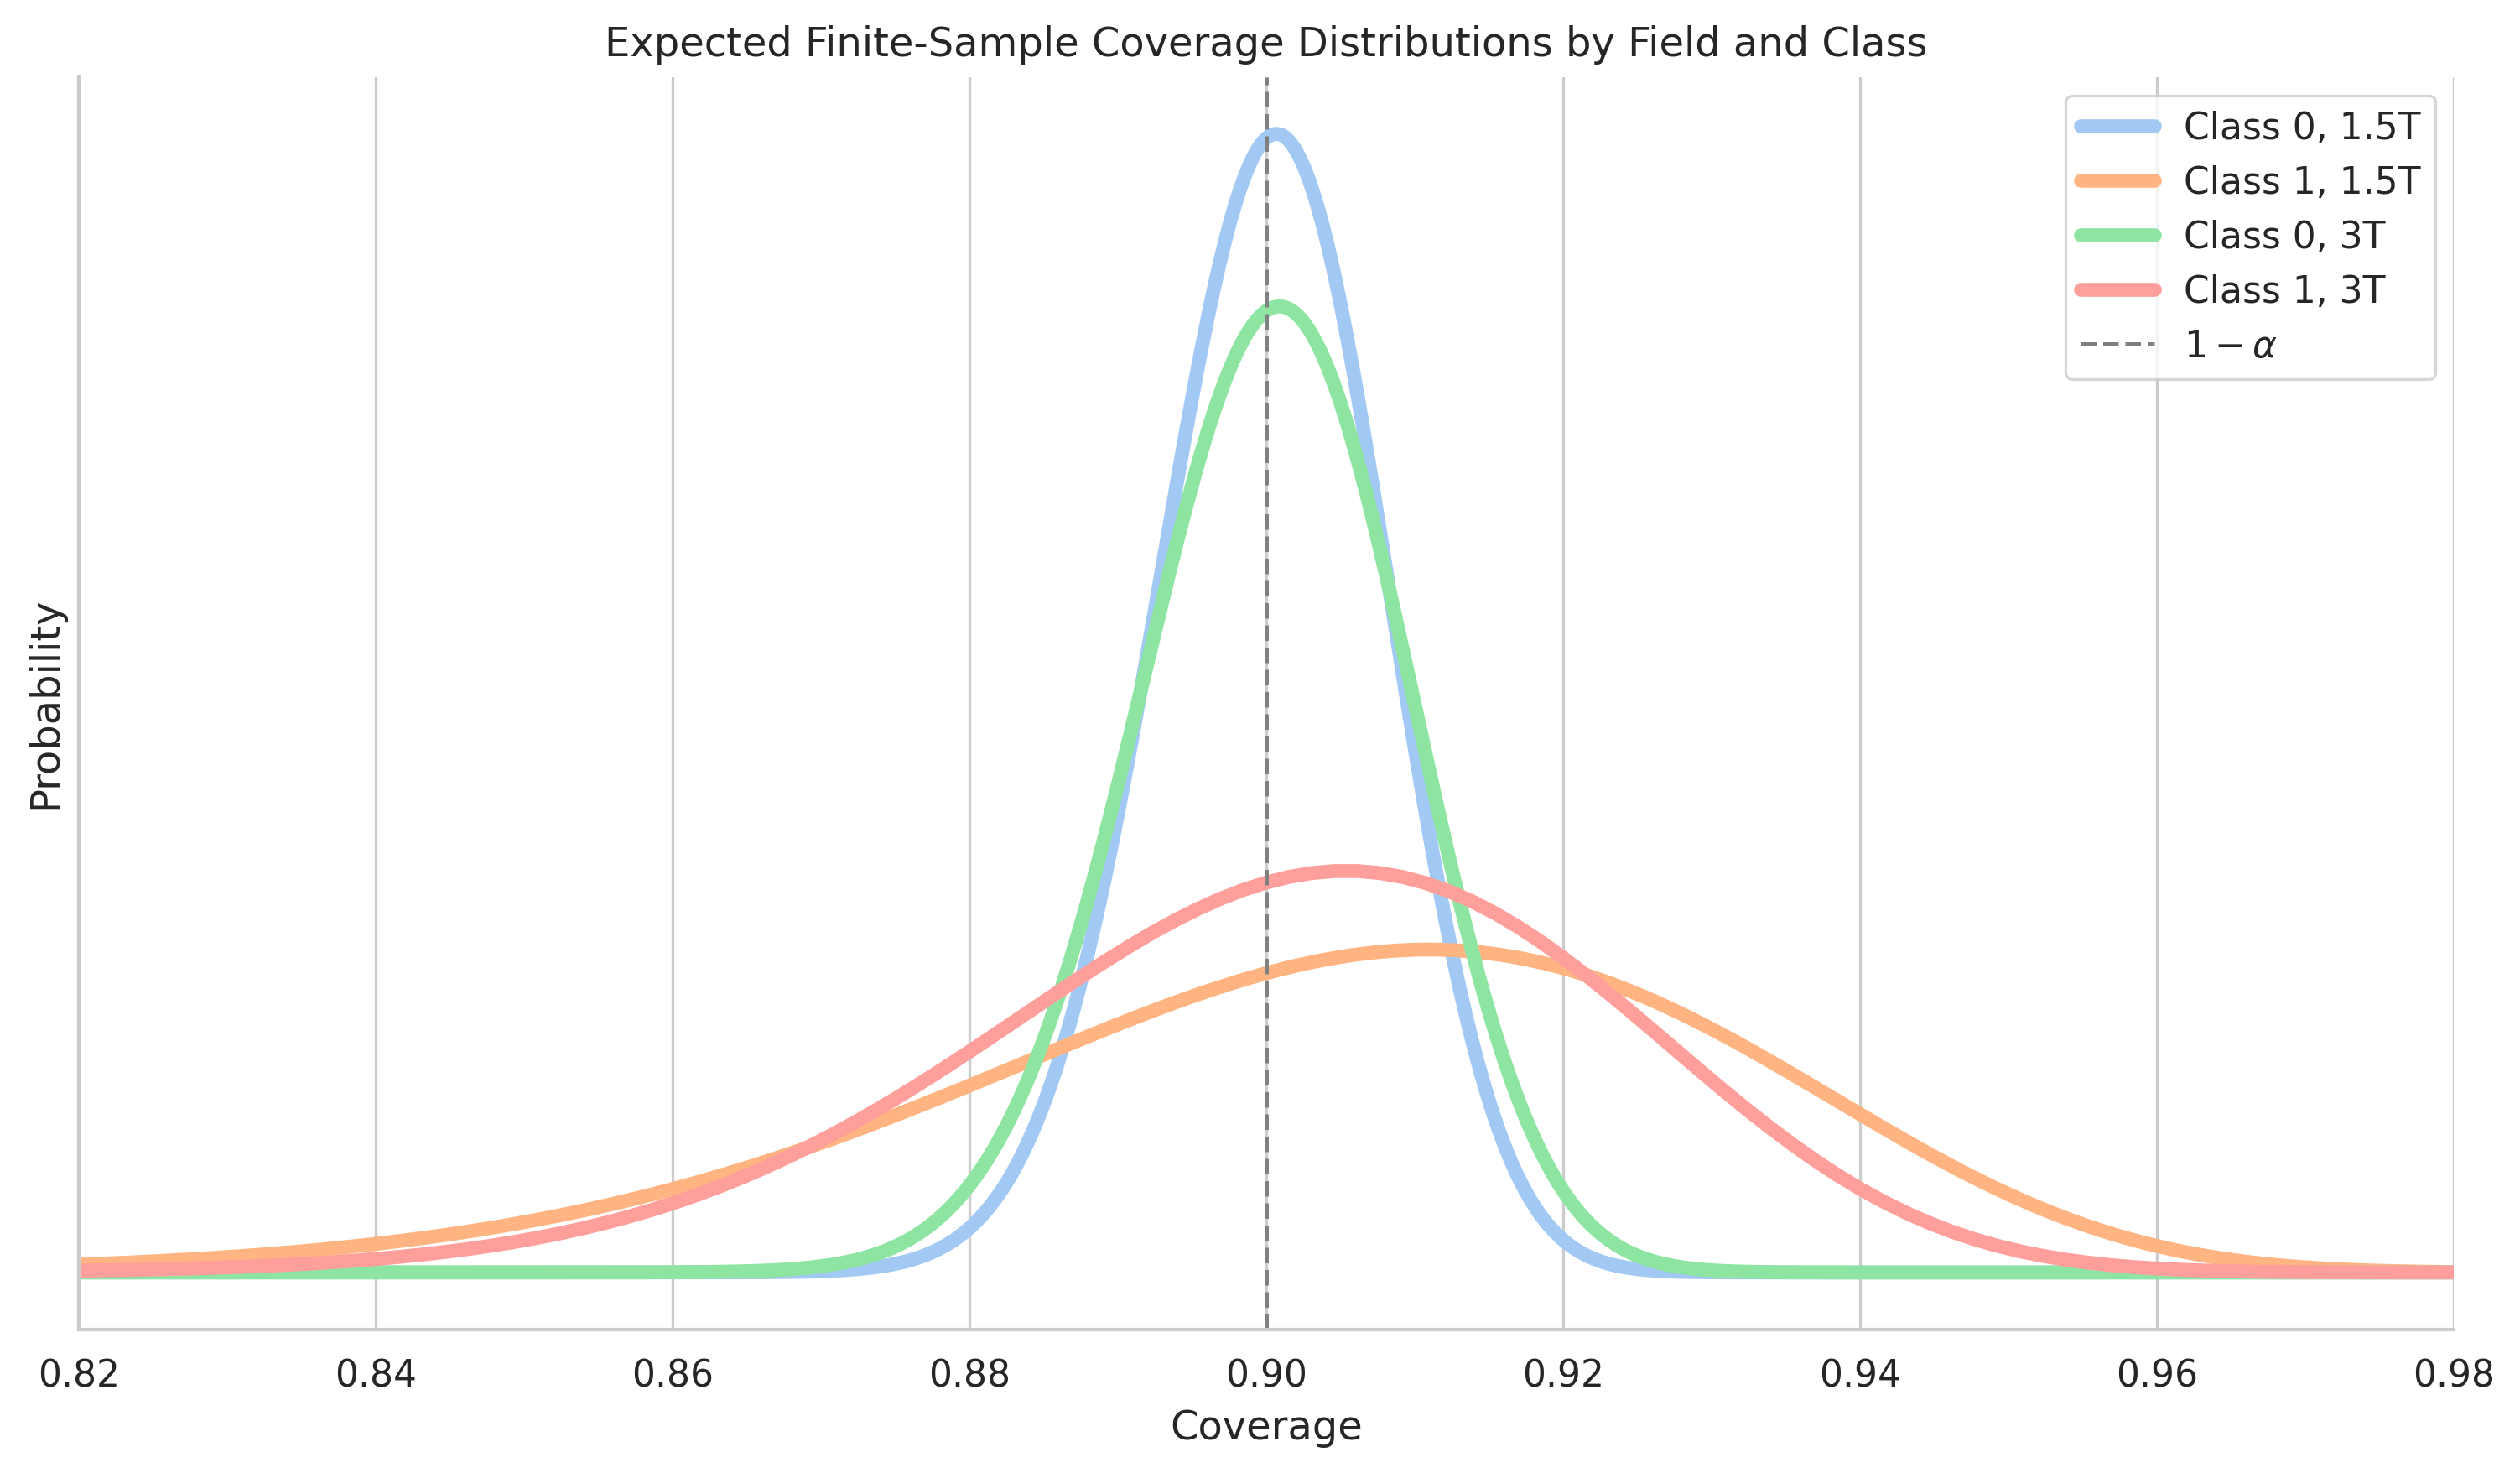

In [7]:
alpha = 0.1

# n_class => number of calibratrion slices corresponding to class
# n_prime_class => number of test slices corresponding to class
#
# params: field → [(n_class0, nprime_class0), (n_class1, nprime_class1)]
params_by_field = {
    'dv1.5T': [(1682, 15217), (124, 1123)],
    'dv3T':   [(1553, 3650),  (253, 650)]
}
min_nprime = 649 # for normalization

classes = ["Class 0", "Class 1"]
fields = ["1.5T", "3T"]

sns.set_palette("pastel")
plt.figure(figsize=(10, 6))
ax = plt.gca()

colors = ['C0', 'C1', 'C2', 'C3']  # one color per combination
labels = []

for idx, field in enumerate(fields):
    for cls_idx, cls in enumerate(classes):
        n, nprime = params_by_field[f'dv{field}'][cls_idx]

        # Beta parameters
        l = np.floor((n + 1) * alpha).astype(int)
        a = n + 1 - l
        b = l

        x = np.arange(0, nprime + 1)
        rv = betabinom(nprime, a, b)

        label = f"{cls}, {field}"
        ax.plot(x / nprime, rv.pmf(x) * (nprime / min_nprime), lw=4, color=colors[idx*2 + cls_idx], label=label)

# vertical line at 1-alpha
ax.axvline(1 - alpha, color="#808080", linestyle="--", label=r"$1-\alpha$")

ax.set_xlabel("Coverage")
ax.set_ylabel("Probability")
ax.set_yticks([])
ax.legend()
sns.despine(top=True, right=True)
plt.title("Expected Finite-Sample Coverage Distributions by Field and Class")
plt.tight_layout()
plt.xlim([0.82,0.98])
plt.savefig('9-4-2__Expected Finite-Sample Coverage Distributions by Field and Class.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

---

---

---

---

---

---